In [1]:
#libraries:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import math

/Users/freeklinssen/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Okay, we start with a nice and simple test example:

We have a school with 1000 kids and want to estimate the probability distribution of what percentage of the kids on this school have read a particular book.

* We survayed 40 kids and 16 of them read the book

* As prior knowledge, we know that the reading percentage of this book at schools across the country is distributed according to the function Beta(3, 7) 


Using Bayes' theorem, we can now derive the posterior probability distribution of the reading percentage at our school based on the survey results and the prior information.




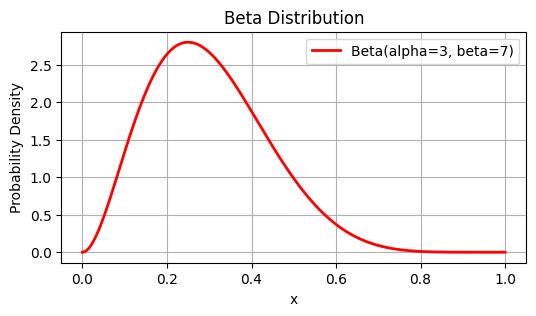

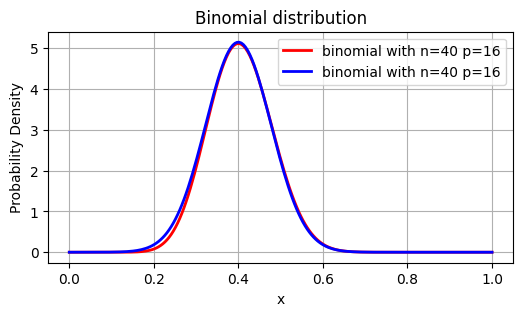

In [2]:
# the distribution in the population (the prior)
alpha = 3
beta = 7
n=40
k=16

x = np.linspace(0, 1, 200)

y = scipy.stats.beta.pdf(x, alpha, beta)

plt.figure(figsize=(6, 3))
plt.plot(x, y, 'r-', lw=2, label=f'Beta(alpha={alpha}, beta={beta})')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Beta Distribution')
plt.legend()
plt.grid(True)
plt.show()


x = np.linspace(0, 1, 200)
y = scipy.stats.binom.pmf(k, n, x)
y_2 =  scipy.stats.norm.pdf(x, (k/n), np.sqrt(n*(k/n)*(1-(k/n)))/n)

plt.figure(figsize=(6, 3))
plt.plot(x, y*n, 'r-', lw=2, label=f'binomial with n={n} p={k}')
plt.plot(x, y_2, 'b-', lw=2, label=f'binomial with n={n} p={k}')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Binomial distribution')
plt.legend()
plt.grid(True)
plt.show()

Basian's theorum tells us that the posterior = likelihood * prior i.e. P(𝜃∣y) ∝ P(y∣𝜃)P(𝜃)

In this case the prior distribution of p is defined by:
* p ∼ Beta(α, β) 

The likelihood of observing the data (number of students who read the book out of those surveyed) can be modeled using a binomial distribution:
* k|p ∼ Binomial(n, p) 

I know that we can calculate the posterior distribution directly for P(p∣k,n)∝P(k∣p,n)⋅P(p) as P(p∣k,n) ∼ Beta(α+k,β+n−k). So this setup makes it easy to test a simple MCMC algorihm and verify its outcome.


To aproximate the posterior distribution through a MCMC algorithm, we need to know one more thing: That the probability density function of Beta(α, β) is defined by B(α,β) * x^α−1 * (1−x)^β−1. Hence, the value of the PDF at a particular x is proportional to  x^α−1 * (1−x)^β−1.
 
​

 




In [58]:
#Metropolis-Hastings Algorithm
class Beta_prior_binomial_data_MCMC:
    def __init__(self, alpha, beta, n, k, sigma=0.01):
        self.alpha = alpha
        self.beta = beta
        self.n = n
        self.k = k
        self.sigma = sigma
        
        self.current_value = np.random.normal(k/n, self.sigma)
        self.current_value = np.clip(self.current_value, 0, 1)
        self.epsilon = 1e-10
        
    def run(self,itterations, burn_in=100):
        
        samples = []
        probability_current_value = self.current_value**(self.alpha-1) * (1-self.current_value)**(self.beta-1) * scipy.stats.binom.pmf(self.p, self.n, self.current_value)
       
        for _ in range(itterations):
            
            new_value = np.random.normal(self.current_value, self.sigma)
            new_value = np.clip(new_value, 0, 1)
            
            prior_density =  new_value**(self.alpha-1) * (1-new_value)**(self.beta-1)
            likelihood = scipy.stats.binom.pmf(self.k, self.n, new_value)
            
            probability_new_value = prior_density * likelihood
            
            #if probability_current_value < self.epsilon:
            #    acceptance_ratio = 1

            acceptance_ratio = probability_new_value/probability_current_value  
            
            if acceptance_ratio > np.random.random():
                self.current_value = new_value
                probability_current_value = probability_new_value
                
            samples.append(self.current_value)  
           
        return samples[burn_in:]

100.00000000000003


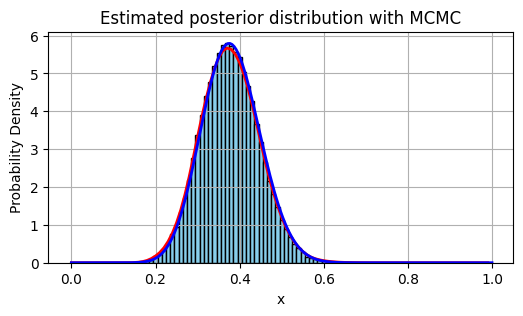

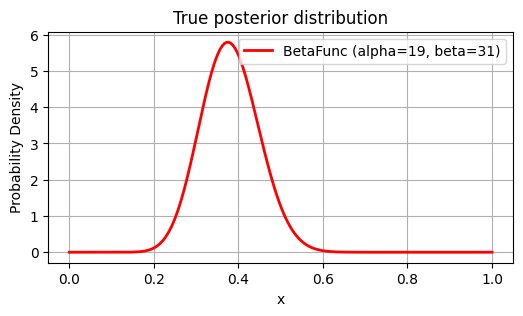

In [61]:
book_example = Beta_prior_binomial_data_MCMC(alpha, beta, n, k)

samples = book_example.run(300000,10000)



# Get counts for each bin
bins = np.arange(0, 1.01, 0.01)
counts, bin_edges = np.histogram(samples, bins=bins)
counts = counts/len(samples)/0.01

print(sum(counts))
smoothed_counts = scipy.ndimage.gaussian_filter1d(counts, sigma=1.5)  #Adjust sigma for smoothness

# for the true distribution:
x = np.linspace(0, 1, 200)
y = scipy.stats.beta.pdf(x, alpha+k, beta+n-k)


# Plotting
plt.figure(figsize=(6, 3))
plt.bar(bin_edges[:-1], counts, width=0.01, color='skyblue', edgecolor='black')
plt.plot(bin_edges[:-1], smoothed_counts, color='red', lw=2, label="Smoothed Fit")
plt.plot(x, y, 'b-', lw=2, label=f'BetaFunc (alpha={alpha}, beta={beta})')

plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Estimated posterior distribution with MCMC')
plt.grid(True)
plt.show()



# The true posterior distribution on its own again:
plt.figure(figsize=(6, 3))
plt.plot(x, y, 'r-', lw=2, label=f'BetaFunc (alpha={alpha+k}, beta={beta-k+n})')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('True posterior distribution')
plt.legend()
plt.grid(True)
plt.show()

the two figures abobe show that the estimated posterior distribution through the MCMC method does indeed resemble the actual posterior distribution